踩地雷本身的遊戲邏輯

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np


class Cell:
    def __init__(self):
        self.is_mine = False
        self.is_revealed = False
        self.adjacent_mines = 0

    def __str__(self):
        if self.is_revealed:
            if self.is_mine:
                return "💣"
            return str(self.adjacent_mines) if self.adjacent_mines > 0 else " "
        return "■"


class Minesweeper:
    def __init__(self, width, height, num_mines):
        self.width = width
        self.height = height
        self.num_mines = num_mines
        self.board = [[Cell() for _ in range(width)] for _ in range(height)] #原始踩地雷棋盤
        self.game_over = False
        self.revealed_cells = 0
        self.step_of_save = 0
        self.total_cells = width * height - num_mines
        self.revealed_positions = set()  # 已翻開格子的集合
        self.neighbor_unrevealed_positions = set()  # 未翻開且在數字旁的格子集合
        self.flag_positions = set() # 插旗子的格子集合
        self.unrevealed_positions = set(i for i in range(height * width))  # 未翻開的格子集合
        self.mine_positions = set()  # 儲存地雷位置的一維索引集合
        self.play_simulation = [[-2 for _ in range(width)] for _ in range(height)]  # 模擬遊玩過程的二維陣列
        self._reset()

    def _place_mines(self):
        mines_placed = self.num_mines
        mine_positions = random.sample(range(self.width * self.height), self.num_mines)  # 隨機選擇地雷的位置
        self.mine_positions = set(mine_positions)  # 將地雷位置存入集合
        for pos in mine_positions:
            x, y = divmod(pos, self.width)  # 將一維索引轉換回二維座標
            self.board[x][y].is_mine = True

    def _calculate_adjacent_mines(self):
        for x in range(self.height):
            for y in range(self.width):
                if not self.board[x][y].is_mine:
                    self.board[x][y].adjacent_mines = self._count_adjacent_mines(x, y)

    def _count_adjacent_mines(self, x, y):
        count = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.height and 0 <= ny < self.width and self.board[nx][ny].is_mine:
                    count += 1
        return count

    def _count_playing_adjacent_unrevealed(self, x, y):
        count = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.height and 0 <= ny < self.width and (self.play_simulation[nx][ny]==-2 or self.play_simulation[nx][ny]==-3):
                    count += 1
        return count

    def _count_playing_adjacent_flags(self, x, y):
        count = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny]==-3:
                    count += 1
        return count

    def _update_neighbor_unrevealed_positions(self):
        """
        更新 neighbor_unrevealed_positions 集合，確保集合只包含「未翻開且在數字旁的格子」。
        使用 play_simulation 的數字作為依據，並排除已插旗的格子。
        """
        self.neighbor_unrevealed_positions.clear()  # 重新初始化集合
        for x in range(self.height):
            for y in range(self.width):
                pos_index = x * self.width + y
                # 根據 play_simulation 判斷：未翻開、未插旗且周圍有數字的格子
                if (
                    self.play_simulation[x][y] == -2  # 未翻開
                    and pos_index not in self.flag_positions  # 未插旗
                ):
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = x + dx, y + dy
                            if (
                                0 <= nx < self.height
                                and 0 <= ny < self.width
                                and self.play_simulation[nx][ny] > 0  # 周圍有數字
                            ):
                                self.neighbor_unrevealed_positions.add(pos_index)
                                break  # 已確認符合條件，跳出內層迴圈
      #  print(self.play_simulation)
      #  print(self.neighbor_unrevealed_positions)

    def _lowest_property(self, x, y): #計算可能為地雷的機率
        sum = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny] > 0:
                    sum += self.play_simulation[nx][ny]
        return sum

    def _reset(self):
        """
        重置遊戲並返回初始狀態（未翻開的棋盤）。
        """
        self.game_over = False
        self.revealed_cells = 0
        self.revealed_positions.clear()
        self.unrevealed_positions = set(i for i in range(self.height * self.width))
        self.neighbor_unrevealed_positions.clear()
        self.flag_positions.clear()
        self.mine_positions.clear()
        self.board = [[Cell() for _ in range(self.width)] for _ in range(self.height)]
        self.play_simulation = [[-2 for _ in range(self.width)] for _ in range(self.height)]  # 重置模擬遊玩過程的二維陣列
        self._place_mines()
        self._calculate_adjacent_mines()

        # 返回初始狀態（棋盤格式，形狀為 height x width）
        return np.full((self.height, self.width, 1), -2)

    def flag_cell(self, x, y):
        """
        在指定格子上插旗，並更新相關狀態與集合。
        """
        # 如果格子已翻開或遊戲已結束，直接返回
        if self.board[x][y].is_revealed or self.game_over:
        #    print(f"格子 ({x}, {y}) 已翻開或遊戲結束，無法插旗。")
            return

        # 插旗邏輯
        self.flag_positions.add(x * self.width + y)
        self.board[x][y].is_revealed = True  # 標記為已翻開
        self.unrevealed_positions.discard(x * self.width + y)  # 從未翻開集合中移除
        self.play_simulation[x][y] = -3  # 更新模擬遊玩過程的二維陣列
        self._update_neighbor_unrevealed_positions()
    #    print(f"成功在格子 ({x}, {y}) 插旗！")


    def reveal_cell(self, x, y):
        """
        翻開指定的格子，處理擴散邏輯，並從未翻開集合中移除，同時維護集合狀態。
        """
        if self.game_over or self.board[x][y].is_revealed:
            return

        # 如果踩到地雷，遊戲結束
        if self.board[x][y].is_mine:
            self.play_simulation[x][y] = -1  # 更新模擬遊玩過程的二維陣列
            self.game_over = True
        #    print(f"💥 踩到地雷！遊戲結束！({x}, {y})")
            return

        # 翻開的格子隊列，用於處理擴散
        cells_to_reveal = [(x, y)]

        while cells_to_reveal:
            cx, cy = cells_to_reveal.pop()

            # 如果格子已翻開，跳過
            if self.board[cx][cy].is_revealed:
                continue

            # 翻開當前格子
            self.board[cx][cy].is_revealed = True
            self.revealed_cells += 1
            self.revealed_positions.add(cx * self.width + cy)
            self.unrevealed_positions.discard(cx * self.width + cy)

            # 更新模擬遊玩過程的二維陣列
            self.play_simulation[cx][cy] = self.board[cx][cy].adjacent_mines

            # 如果是空白格子，加入相鄰格子進一步擴散
            if self.board[cx][cy].adjacent_mines == 0:
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = cx + dx, cy + dy
                        if 0 <= nx < self.height and 0 <= ny < self.width and not self.board[nx][ny].is_revealed:
                            cells_to_reveal.append((nx, ny))

        # 如果所有非地雷格子已翻開，標記為成功
        if self.revealed_cells == self.total_cells and not self.game_over:
            self.game_over = True
        #    print("🎉 恭喜！你贏了！")

        # 統一更新 neighbor_unrevealed_positions
        self._update_neighbor_unrevealed_positions()

    def save_play_simulation(self, filename, x, y):
        """
        將 play_simulation 儲存成 .txt 檔案，數字 (0-8) 與未翻開格子 (9)。
        """
        with open(filename, "a") as file:
            file.write(f"{self.step_of_save}\n")
            self.step_of_save += 1

            for row in self.play_simulation:
                line = " ".join(str(cell if cell >= 0 else 9) for cell in row)
                file.write(line + "\n")
            file.write(f"{x} {y}\n\n")

    def _algo_flag_cell(self, Print_board):
        """
        封裝插旗子的邏輯。
        """
        oper_times = 0
        for x in range(self.height):
            for y in range(self.width):
                if self.play_simulation[x][y] > 0 and self.play_simulation[x][y] == self._count_playing_adjacent_unrevealed(x, y):
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if dx == 0 and dy == 0:
                                continue
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny] == -2:
                                if self.flag_cell(nx, ny):
                                    oper_times += 1
                                    if Print_board >= 3:
                                        print(f"插旗 X:{nx}, Y:{ny}")
        return oper_times

    def _algo_reveal_cell(self, Print_board, output_file):
        """
        封裝翻開格子的邏輯。
        """
        oper_times = 0
        for x in range(self.height):
            for y in range(self.width):
                if self.play_simulation[x][y] > 0 and self.play_simulation[x][y] == self._count_playing_adjacent_flags(x, y):
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if dx == 0 and dy == 0:
                                continue
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny] == -2:
                                self.save_play_simulation(output_file, nx, ny)
                                self.reveal_cell(nx, ny)
                                oper_times += 1
                                if Print_board >= 3:
                                    print(f"翻開 X:{nx}, Y:{ny}")
        return oper_times

    def _low_prop_reveal_cell(self, Print_board):
        # 初始化最小分數與最佳位置
        min_score = float('inf')
        best_position = None

        # 遍歷所有格子，計算分數
        for pos in self.neighbor_unrevealed_positions:
            x, y = divmod(pos, self.width)  # 一維轉二維
            score = self._lowest_property(x, y)  # 計算當前格子的分數
            if score < min_score:
                min_score = score
                best_position = (x, y)

        # 翻開分數最低的格子
        if best_position:
            x, y = best_position
            if Print_board >= 3:
                print(f"翻開機率最低的格子 X:{x}, Y:{y}")
            self.reveal_cell(x, y)

    def _rand_reveal_cell(self, Print_board):
        # 隨機選擇一個未翻開的格子
        random_element = random.choice(list(self.unrevealed_positions))
        X, Y = divmod(random_element, self.width)
        self.reveal_cell(X, Y)
        if Print_board >= 3:
            print(f"隨機翻開 X:{X}, Y:{Y}")

    def _correct_reveal_cell(self, output_file, Print_board):
        """
        隨機選擇一個安全的未翻開格子並翻開它。
        返回翻開的次數：1 表示成功翻開一個格子，0 表示沒有可翻開的格子。
        """
        # 計算安全的未翻開格子（即未插旗且非地雷）
        safe_unrevealed_positions = self.unrevealed_positions - self.mine_positions
    
        if not safe_unrevealed_positions:
            # 如果沒有安全的格子，返回 0
            return 0
    
        # 隨機選擇一個安全的格子
        selected_pos = random.choice(list(safe_unrevealed_positions))
        x, y = divmod(selected_pos, self.width)
    
        # 翻開該格子
        self.reveal_cell(x, y)
        self.save_play_simulation(output_file, x, y)
    
        # 如果需要，打印翻開的格子位置
        if Print_board >= 3:
            print(f"隨機翻開安全的格子 X:{x}, Y:{y}")
    
        return 1  # 表示成功翻開一個格子

    def _neighbor_correct_reveal_cell(self, output_file, Print_board):
        """
        從 neighbor_unrevealed_positions 集合中隨機選擇一個未翻開且在數字旁的格子進行翻開，
        並確保該格子不是地雷。
        """
        available_positions = self.neighbor_unrevealed_positions - self.mine_positions
        
        if not available_positions:
            # 沒有符合條件的格子，返回 0
            self. _correct_reveal_cell(output_file, Print_board)
            return 0

        # 隨機選擇一個未翻開且在數字旁的格子，且不是地雷
        selected_pos = random.choice(list(available_positions))
        x, y = divmod(selected_pos, self.width)  # 將一維索引轉換為二維座標

        # 翻開該格子並保存步驟
        self.save_play_simulation(output_file, x, y)
        self.reveal_cell(x, y)
        
        if Print_board >= 3:
            print(f"從已揭開的格子的周圍隨機選擇並翻開格子 X:{x}, Y:{y}")
        
        return 1  # 表示成功翻開了一個格子

    
    def _upscale_logic_reveal_cell(self, Print_board, output_file):
        temp_play_simulation = [row[:] for row in self.play_simulation]  # 模擬遊玩過程的二維陣列 (扣掉周圍旗子的數字)
        oper_times = 0
        for x in range(self.height):
            for y in range(self.width):
                if self.play_simulation[x][y] >= 0:
                    temp_play_simulation[x][y] -= self._count_playing_adjacent_flags(x, y)
        #        print(f"{temp_play_simulation[x][y]:2}", end=" ")
        #    print()
    
        for x in range(self.height-2): #直的121
            for y in range(self.width):
                if temp_play_simulation[x][y] == 1 and temp_play_simulation[x+1][y] == 2 and temp_play_simulation[x+2][y] == 1:
                    if 0 <= x+1 < self.height and 0 <= y-1 < self.width and self.play_simulation[x+1][y-1] == -2:
                        self.save_play_simulation(output_file, x+1, y-1)
                        self.reveal_cell(x+1, y-1)
                        if Print_board >= 3:
                            print(f"利用121邏輯翻開 X:{x+1}, Y:{y-1}")
                        oper_times += 1
                    if 0 <= x+1 < self.height and 0 <= y+1 < self.width and self.play_simulation[x+1][y+1] == -2:
                        self.save_play_simulation(output_file, x+1, y+1)
                        self.reveal_cell(x+1, y+1)
                        if Print_board >= 3:
                            print(f"利用121邏輯翻開 X:{x+1}, Y:{y+1}")
                        oper_times += 1

        for x in range(self.height): #橫的121
            for y in range(self.width-2):
                if temp_play_simulation[x][y] == 1 and temp_play_simulation[x][y+1] == 2 and temp_play_simulation[x][y+2] == 1:
                    if 0 <= x-1 < self.height and 0 <= y+1 < self.width and self.play_simulation[x-1][y+1] == -2:
                        self.save_play_simulation(output_file, x-1, y+1)
                        self.reveal_cell(x-1, y+1)
                        if Print_board >= 3:
                            print(f"利用121邏輯翻開 X:{x-1}, Y:{y+1}")
                        oper_times += 1
                    if 0 <= x+1 < self.height and 0 <= y+1 < self.width and self.play_simulation[x+1][y+1] == -2:
                        self.save_play_simulation(output_file, x+1, y+1)
                        self.reveal_cell(x+1, y+1)
                        if Print_board >= 3:
                            print(f"利用121邏輯翻開 X:{x+1}, Y:{y+1}")
                        oper_times += 1

        for x in range(self.height-3): #直的1221
            for y in range(self.width):
                if temp_play_simulation[x][y] == 1 and temp_play_simulation[x+1][y] == 2 and temp_play_simulation[x+2][y] == 2 and temp_play_simulation[x+3][y] == 1:
                    if 0 <= x < self.height and 0 <= y-1 < self.width and self.play_simulation[x][y-1] == -2:
                        self.save_play_simulation(output_file, x, y-1)
                        self.reveal_cell(x, y-1)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x}, Y:{y-1}")
                        oper_times += 1
                    if 0 <= x < self.height and 0 <= y+1 < self.width and self.play_simulation[x][y+1] == -2:
                        self.save_play_simulation(output_file, x, y+1)
                        self.reveal_cell(x, y+1)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x}, Y:{y+1}")
                        oper_times += 1
                    if 0 <= x+3 < self.height and 0 <= y-1 < self.width and self.play_simulation[x+3][y-1] == -2:
                        self.save_play_simulation(output_file, x+3, y-1)
                        self.reveal_cell(x+3, y-1)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x+3}, Y:{y-1}")
                        oper_times += 1
                    if 0 <= x+3 < self.height and 0 <= y+1 < self.width and self.play_simulation[x+3][y+1] == -2:
                        self.save_play_simulation(output_file, x+3, y+1)
                        self.reveal_cell(x+3, y+1)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x+3}, Y:{y+1}")
                        oper_times += 1

        for x in range(self.height): #橫的1221
            for y in range(self.width-3):
                if temp_play_simulation[x][y] == 1 and temp_play_simulation[x][y+1] == 2 and temp_play_simulation[x][y+2] == 2 and temp_play_simulation[x][y+3] == 1:
                    if 0 <= x-1 < self.height and 0 <= y < self.width and self.play_simulation[x-1][y] == -2:
                        self.save_play_simulation(output_file, x-1, y)
                        self.reveal_cell(x-1, y)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x-1}, Y:{y}")
                        oper_times += 1
                    if 0 <= x+1 < self.height and 0 <= y < self.width and self.play_simulation[x+1][y] == -2:
                        self.save_play_simulation(output_file, x+1, y)
                        self.reveal_cell(x+1, y)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x+1}, Y:{y}")
                        oper_times += 1
                    if 0 <= x-1 < self.height and 0 <= y+3 < self.width and self.play_simulation[x-1][y+3] == -2:
                        self.save_play_simulation(output_file, x-1, y+3)
                        self.reveal_cell(x-1, y+3)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x-1}, Y:{y+3}")
                        oper_times += 1
                    if 0 <= x+1 < self.height and 0 <= y+3 < self.width and self.play_simulation[x+1][y+3] == -2:
                        self.save_play_simulation(output_file, x+1, y+3)
                        self.reveal_cell(x+1, y+3)
                        if Print_board >= 3:
                            print(f"利用1221邏輯翻開 X:{x+1}, Y:{y+3}")
                        oper_times += 1
        
        return oper_times
        
    def _upscale_logic_reveal_cell2(self, Print_board, output_file):
        temp_play_simulation = [row[:] for row in self.play_simulation]  # 模擬遊玩過程的二維陣列 (扣掉周圍旗子的數字)
        oper_times = 0
        for x in range(self.height):
            for y in range(self.width):
                if self.play_simulation[x][y] >= 0:
                    temp_play_simulation[x][y] -= self._count_playing_adjacent_flags(x, y)

        for x in range(self.height):
            for y in range(self.width):
                if self.play_simulation[x][y] == -2:
                    continue
                mark = [[0 for _ in range(self.width)] for _ in range(self.height)]
                total_mark = 0
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny] == -2:
                            mark[nx][ny] = 1
                            total_mark += 1
               # print(x, y)
               # print(mark)
                
                for dx in [-2, -1, 0, 1, 2]:
                    for dy in [-2, -1, 0, 1, 2]:
                        if dx == 0 and dy == 0:
                            continue
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < self.height and 0 <= ny < self.width and self.play_simulation[nx][ny]>0 and temp_play_simulation[x][y] == temp_play_simulation[nx][ny]:
                            now_mark = 0
                            for Dx in [-1, 0, 1]:
                                for Dy in [-1, 0, 1]:
                                    Nx, Ny = nx + Dx, ny + Dy
                                    if 0 <= Nx < self.height and 0 <= Ny < self.width and mark[Nx][Ny] == 1:
                                        now_mark += 1
                            if total_mark == now_mark:
                                for Dx in [-1, 0, 1]:
                                    for Dy in [-1, 0, 1]:
                                        Nx, Ny = nx + Dx, ny + Dy
                                        if 0 <= Nx < self.height and 0 <= Ny < self.width and mark[Nx][Ny] == 0 and self.play_simulation[Nx][Ny] == -2:
                                            self.save_play_simulation(output_file, Nx, Ny)
                                            self.reveal_cell(Nx, Ny)
                                            if Print_board >= 3:
                                                print(f"利用高級邏輯排除 X:{Nx}, Y:{Ny}")
                                            #    print(f"x: {x}, y: {y}, nx: {nx}, ny: {ny}, Nx: {Nx}, Ny: {Ny}\n")
                                                self.draw_board(flag=0)
                                            return 1
                                            
        return oper_times
                            
    
    def initialize_with_map(self, map_layout):
        """
        使用自定義地圖初始化遊戲。

        :param map_layout: 二維列表，表示地圖布局。
                           0 表示無地雷，1 表示有地雷。
        """
        self.height = len(map_layout)
        self.width = len(map_layout[0])
        self.num_mines = sum(row.count(1) for row in map_layout)

        # 初始化地圖
        self.board = [[Cell() for _ in range(self.width)] for _ in range(self.height)]
        self.mine_positions.clear()
        self.unrevealed_positions = set(i for i in range(self.height * self.width))

        for x in range(self.height):
            for y in range(self.width):
                if map_layout[x][y] == 1:
                    self.board[x][y].is_mine = True
                    self.mine_positions.add(x * self.width + y)

        # 計算每個格子的鄰近地雷數
        self._calculate_adjacent_mines()

        # 重置其他遊戲狀態
        self.play_simulation = [[-2 for _ in range(self.width)] for _ in range(self.height)]
        self.revealed_cells = 0
        self.revealed_positions.clear()
        self.neighbor_unrevealed_positions.clear()
        self.flag_positions.clear()
        self.game_over = False
        self.total_cells = self.width * self.height - self.num_mines

    
    def algorithm_reveal_cell(self, Print_board=0, first_step=2, output_file="Minesweeper_Beginner_dataset.txt"):
        """
        利用演算法踩地雷
        """
        """
        # 指定自定義地圖
        custom_map = [
            [0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0],
        ]
        self.initialize_with_map(custom_map)
        """
        
        if Print_board >= 1 or Print_board == 1:
            self.draw_board(flag=1)
            
        
        if first_step == 2:
            # 找出所有數字為 0 的格子
            zero_positions = [
                (i, j) for i in range(self.height) for j in range(self.width)
                if self.board[i][j].adjacent_mines == 0 and not self.board[i][j].is_mine
            ]

            # 隨機選擇其中一個格子作為第一步
            if zero_positions:
                x, y = random.choice(zero_positions)
                self.reveal_cell(x, y)
        
        
        while not self.game_over:
            oper_times = 0
            oper_times += self._algo_flag_cell(Print_board)                #利用簡單邏輯去插旗子
            oper_times += self._algo_reveal_cell(Print_board, output_file) #利用簡單邏輯去翻格子
            
            if Print_board >= 2:
                self.draw_board(flag=0)

            if self.game_over:
                break

            if oper_times == 0: 
                #啟用121與1221的高級邏輯
                oper_times += self._upscale_logic_reveal_cell(Print_board, output_file)

            if oper_times == 0: 
                #起用高級邏輯
                oper_times += self._upscale_logic_reveal_cell2(Print_board, output_file)
                
            """
            if oper_times == 0 and len(self.neighbor_unrevealed_positions) > 0:
                self._low_prop_reveal_cell(Print_board) #去翻機率最低的格子
            """
            if oper_times == 0:
            #    self. _rand_reveal_cell(Print_board) #隨機翻
            #    self. _correct_reveal_cell(output_file, Print_board) #翻一定正確的一格
                self. _neighbor_correct_reveal_cell(output_file, Print_board) #翻已揭開周圍一定正確的一格

        if Print_board >= 1:
            self.draw_board(flag=0)
        if self.revealed_cells != self.total_cells and Print_board == -1:
        #    self.draw_board(flag=1)
            self.draw_board(flag=0)

    def draw_board(self, flag=0):
        """
        根據 flag 的數值繪製遊戲棋盤。
        flag=0 顯示 play_simulation，flag=1 顯示 board。
        """
        # 選擇數據源
        if flag == 0:
            data = self.play_simulation
        elif flag == 1:
            data = [[-1 if cell.is_mine else cell.adjacent_mines if cell.is_revealed else -2
                    for cell in row] for row in self.board]
        else:
            raise ValueError("Invalid flag value. Use 0 for play_simulation or 1 for board.")

        # 設定顏色圖 (漸層色)
        cmap = plt.cm.Blues  # 使用藍色漸層
        norm = plt.Normalize(vmin=0, vmax=8)  # 0 表示白色，8 表示最深的藍色

        fig, ax = plt.subplots(figsize=(self.width / 2, self.height / 2))
        for i in range(self.height):
            for j in range(self.width):
                value = data[i][j]
                pos_index = i * self.width + j  # 計算一維索引以匹配 flag_positions

                # 決定顏色
                if value == -3:  # 插旗的格子
                    color = "gray"
                elif value == -2:  # 未翻開的格子
                    color = "gray"
                elif value == -1:  # 採到地雷
                    color = "red"
                elif value == 0:  # 空白格子
                    color = "white"
                else:  # 數字格子
                    color = cmap(norm(value))

                # 繪製格子背景
                rect = plt.Rectangle((j, self.height - i - 1), 1, 1, facecolor=color, edgecolor="black")
                ax.add_patch(rect)

                # 顯示旗子或數字
                if value == -3:  # 插旗的格子顯示 "P"
                    ax.text(j + 0.5, self.height - i - 1 + 0.5, "P", ha="center", va="center", fontsize=10, color="white")
                elif value > 0:  # 顯示數字
                    ax.text(j + 0.5, self.height - i - 1 + 0.5, str(int(value)), ha="center", va="center", fontsize=8)

        # 添加行列標籤
        for i in range(self.height):
            ax.text(-0.5, self.height - i - 1 + 0.5, str(i), ha="center", va="center", fontsize=10)
        for j in range(self.width):
            ax.text(j + 0.5, self.height + 0.2, str(j), ha="center", va="center", fontsize=10)

        ax.set_xlim(-1, self.width)
        ax.set_ylim(-1, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.gca().set_aspect("equal", adjustable="box")
        plt.show()


模擬遊戲與產生資料集

In [4]:
def play_game(width=9, height=9, num_mines=10, loop=10000, Print_board=0, first_step=2):
    print("歡迎來到踩地雷遊戲！")
    game = Minesweeper(width, height, num_mines)
    win = 0

#    output_file="/kaggle/working/Minesweeper_test.txt"
#    output_file="/kaggle/working/Minesweeper_Beginner_50000_nbr_cor_up_dataset.txt"
#    output_file="/kaggle/working/Minesweeper_Intermediate_20000_nbr_cor_up_dataset.txt"
    output_file="/kaggle/working/Minesweeper_Expert_4000_nbr_cor_up_dataset.txt"
    with open(output_file, "a") as file:
        file.write(f"{width} {height}\n\n")

    for i in range(loop):
        # 讓演算法去踩地雷
        game._reset()
        if i%100==0:
            print(i)
        game.algorithm_reveal_cell(Print_board=Print_board, output_file=output_file, first_step=first_step)
        if game.game_over and game.revealed_cells == game.total_cells:
            win += 1

    print(f"Win rate: {win/loop}")

if __name__ == "__main__":
    play_game(width=30, height=16, num_mines=99, loop=4000, Print_board=0, first_step=2)


歡迎來到踩地雷遊戲！
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
Win rate: 1.0


資料增強

In [1]:
import numpy as np

def rotate_coordinates(x, y, height, width, angle):
    """
    根據角度旋轉座標。
    """
    if angle == 0:
        return x, y
    elif angle == 90:
        return width - 1 - y, x
    elif angle == 180:
        return height - 1 - x, width - 1 - y
    elif angle == 270:
        return y, height - 1 - x
    else:
        raise ValueError("Invalid rotation angle. Use 0, 90, 180, or 270.")

def augment_board(board, coord, height, width):
    """
    對棋盤進行左右鏡像和旋轉，並生成增強後的棋盤及翻格座標。
    """
    augmented_boards = []
    augmented_coords = []

    for angle in [0, 90, 180, 270]:
        rotated_board = np.rot90(board, k=angle // 90)
        rotated_x, rotated_y = rotate_coordinates(coord[0], coord[1], height, width, angle)
        augmented_boards.append(rotated_board)
        augmented_coords.append((rotated_x, rotated_y))

    # 左右鏡像
    mirrored_board = np.fliplr(board)
    mirrored_x, mirrored_y = coord[0], width - 1 - coord[1]
    for angle in [0, 90, 180, 270]:
        rotated_board = np.rot90(mirrored_board, k=angle // 90)
        rotated_x, rotated_y = rotate_coordinates(mirrored_x, mirrored_y, height, width, angle)
        augmented_boards.append(rotated_board)
        augmented_coords.append((rotated_x, rotated_y))

    return augmented_boards, augmented_coords

def parse_and_augment_dataset(file_path, output_path):
    """
    解析資料集並進行資料增強，輸出增強後的資料集。
    """
    board = []
    pos = []
    temp_board = []
    line_num = 0

    with open(file_path, "r") as file:
        lines = file.readlines()

    height, width = map(int, lines[0].strip().split())
    
    total_height = height + 3
    height1 = height + 1
    height2 = height + 2

    augmented_boards = []
    augmented_positions = []

    for line in lines[1:]:
        line = line.strip()

        if 1 < line_num % total_height <= height1:  # 棋盤行
            row = [int(x) for x in line.split()]
            temp_board.append(row)
        elif line_num % total_height == height2:  # 座標行
            x, y = map(int, line.split())
            
            augmented_b, augmented_p = augment_board(np.array(temp_board), (x, y), height, width)
            augmented_boards.extend(augmented_b)
            augmented_positions.extend(augmented_p)

            temp_board = []

        line_num += 1

    num = 0
    # 輸出增強後的資料集
    with open(output_path, "w") as file:
        file.write(f"{height} {width}\n\n")
        for board, (x, y) in zip(augmented_boards, augmented_positions):
            file.write(f"{num}\n")
            num += 1
            for row in board:
                file.write(" ".join(map(str, row)) + "\n")
            file.write(f"{x} {y}\n")
            file.write("\n")

if __name__ == "__main__":
    input_file = "/kaggle/input/minesweeper-beginner-10000-dataset-human/Minesweeper_Beginner_10000_datasethuman.txt"  # 輸入檔案路徑
    output_file = "/kaggle/working/Minesweeper_Beginner_Enhancement_10000_dataset+human.txt"  # 輸出檔案路徑

    parse_and_augment_dataset(input_file, output_file)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/minesweeper-beginner-10000-dataset-human/Minesweeper_Beginner_10000_datasethuman.txt'

模型建構與訓練

30 16
處理進度: |█████████████████████████████-| 833800/833897 (100.0%)
資料集處理完成


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1735949299.483435      66 service.cc:145] XLA service 0x798188001b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735949299.483529      66 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735949299.483537      66 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1735949321.451495      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 215s 587ms/step - accuracy: 0.0054 - loss: 5.6620 - val_accuracy: 0.0365 - val_loss: 4.8684
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 177s 544ms/step - accuracy: 0.0536 - loss: 4.6882 - val_accuracy: 0.2057 - val_loss: 3.6783
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.1676 - loss: 3.8590 - val_accuracy: 0.3480 - val_loss: 3.1421
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.2755 - loss: 3.3828 - val_accuracy: 0.4100 - val_loss: 2.8698
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.3443 - loss: 3.0822 - val_accuracy: 0.4493 - val_loss: 2.6918
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.3850 - loss: 2.8829 - val_accuracy: 0.4709 - val_loss: 2.5829
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.4149 - loss: 2.7357 - val_accuracy: 0.4864 - val_loss: 2.4938
Epoch 8/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 178s 545ms/step - accuracy: 0.4367 - loss: 2.61

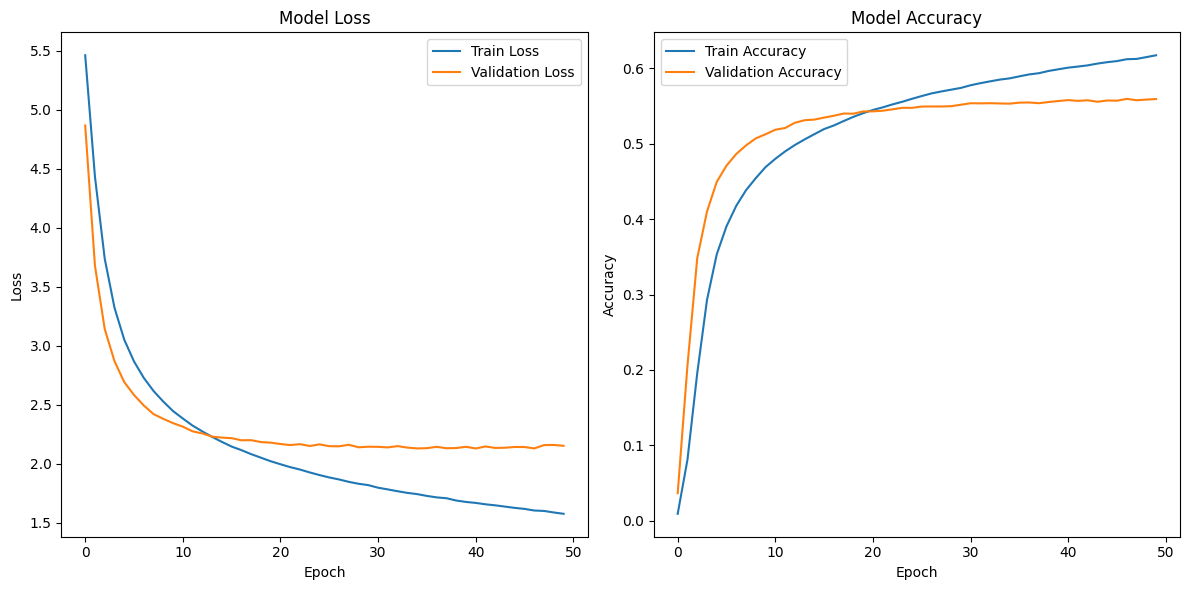

模型已保存至 /kaggle/working/minesweeper_Expert_50epochs_nbr_cor_up.h5


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

def parse_dataset(file_path):
    """
    解析資料集，將每筆資料轉換為棋盤 (輸入) 和對應的翻格座標 (標籤)。
    """
    import sys

    board = []
    pos = []
    temp_board = []
    line_num = 0

    with open(file_path, "r") as file:
        lines = file.readlines()

    height, width = map(int, lines[0].strip().split())

    print(height, width)
    
    total_height = width + 3
    height1 = width + 1
    height2 = width + 2

    total_entries = len(lines) // total_height  # 總筆數

    for line in lines[1:]:
        
        line = line.strip()
        
        if 1 < line_num % total_height <= height1:  # 棋盤行
            row = [((int(x) if int(x) != 9 else -8) / 8.0) for x in line.split()]
            temp_board.append(row)
        elif line_num % total_height == height2:  # 座標行
            x, y = map(int, line.split())
        #    print(f"{x}, {y}\n")
            
            board.append(temp_board)
            pos.append(x * width + y)  # 將 (x, y) 轉為一維索引
            temp_board = []

        # 動態進度條
        if line_num % total_height == 0:
            progress = line_num // total_height
            progress_ratio = progress / total_entries
            bar_length = 30  # 進度條長度
            filled_length = int(bar_length * progress_ratio)
            bar = '█' * filled_length + '-' * (bar_length - filled_length)
            if progress % 100 == 0:  # 每 100 筆資料更新一次
                sys.stdout.write(f'\r處理進度: |{bar}| {progress}/{total_entries} ({progress_ratio:.1%})')
                sys.stdout.flush()

        line_num += 1

    print()  # 進度條結束後換行

    inputs = np.array(board).reshape(-1, height, width, 1)  # CNN 輸入需為四維
    labels = np.array(pos)  # 標籤轉為 numpy 陣列
    return inputs, labels, height, width


def build_model(input_shape, output_classes):
    """
    建立 CNN 模型，加入 Dropout 以防止過擬合。
    """
    model = Sequential([
        Conv2D(128, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),  # 隨機丟棄 30% 的神經元
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # 在全連接層增加 Dropout
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(output_classes, activation='softmax')  # 預測座標 (x, y)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def train_model(dataset_path, epochs=10, batch_size=32):
    """
    訓練 CNN 模型。
    """
    inputs, labels, height, width = parse_dataset(dataset_path)
    print("資料集處理完成")
    output_classes = height * width  # 總類別數 (所有格子)
    
    # 分割訓練集和測試集
    split_idx = int(len(inputs) * 0.8)
    x_train, x_test = inputs[:split_idx], inputs[split_idx:]
    y_train, y_test = labels[:split_idx], labels[split_idx:]

    model = build_model(input_shape=x_train.shape[1:], output_classes=output_classes)
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True)
    return model, history
    
def plot_training_history(history):
    """
    繪製訓練過程的 Loss 和 Accuracy 曲線。
    """
    plt.figure(figsize=(12, 6))

    # Loss 曲線
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 曲線
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    dataset_path = "/kaggle/input/minesweeper-up-dataset/Minesweeper_Expert_4000_nbr_cor_up_dataset.txt"  # 替換為資料集路徑
    model, history = train_model(dataset_path, epochs=50, batch_size=2048)
    
    # 繪製訓練過程的 Loss 和準確率曲線
    plot_training_history(history)

    # 保存模型
    model_save_path = "/kaggle/working/minesweeper_Expert_50epochs_nbr_cor_up.h5"  # 模型保存的路徑
    model.save(model_save_path)
    print(f"模型已保存至 {model_save_path}")

模型測試

模擬遊戲中:   2%|▏         | 8/500 [00:10<12:02,  1.47s/it]

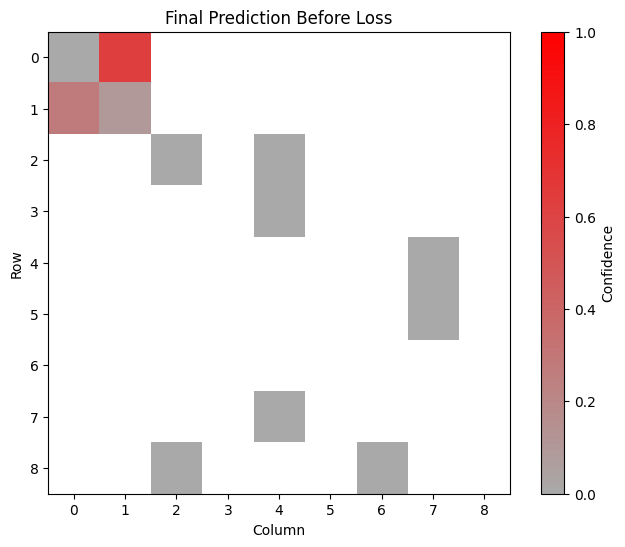

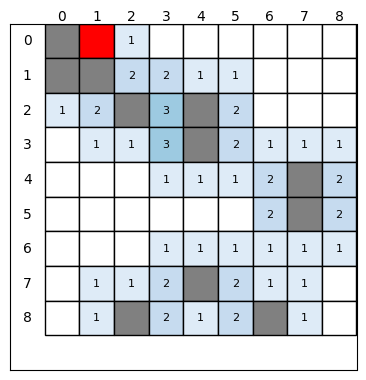

模擬遊戲中:   4%|▍         | 19/500 [00:26<11:04,  1.38s/it]

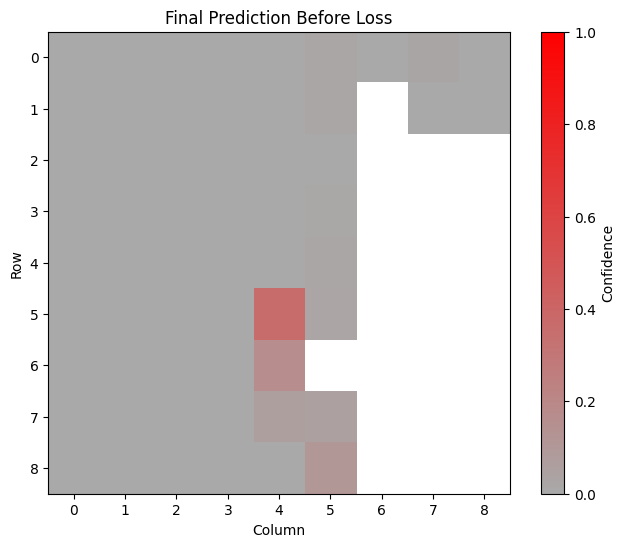

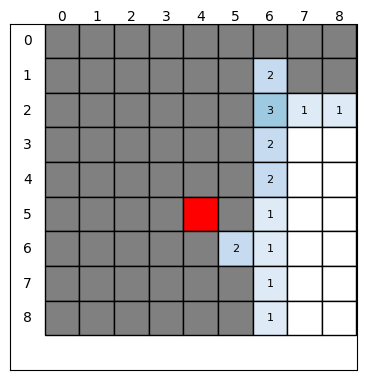

模擬遊戲中:   4%|▍         | 22/500 [00:29<10:49,  1.36s/it]

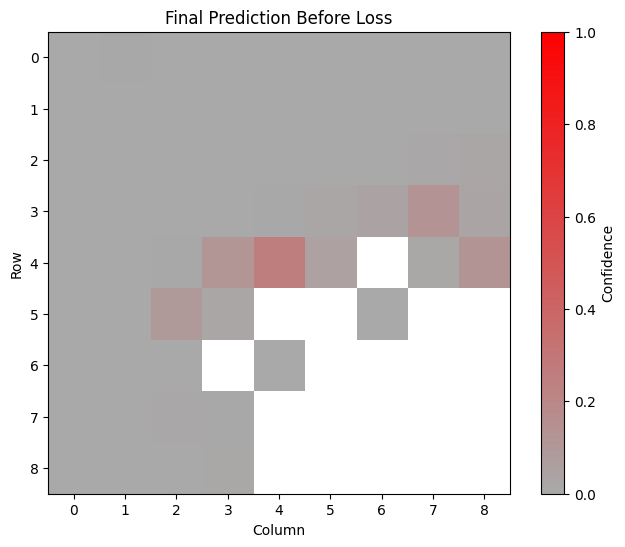

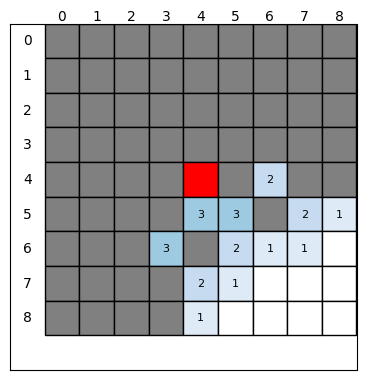

模擬遊戲中:   7%|▋         | 33/500 [00:45<10:35,  1.36s/it]

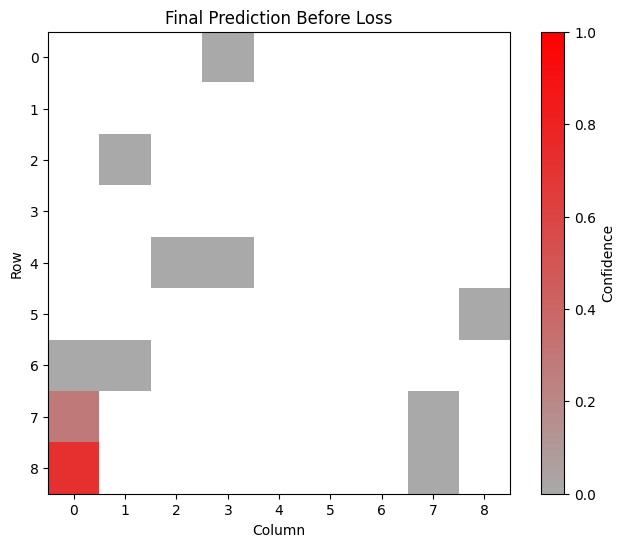

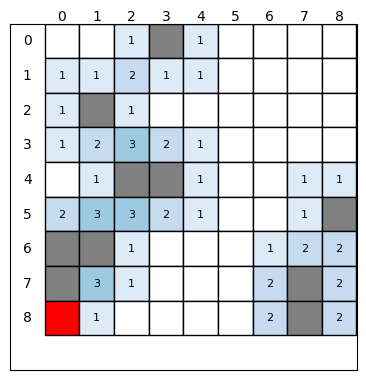

模擬遊戲中:   7%|▋         | 37/500 [00:51<10:35,  1.37s/it]

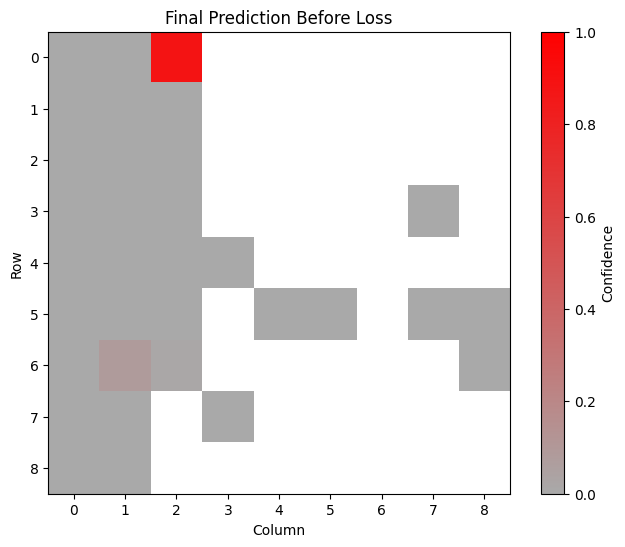

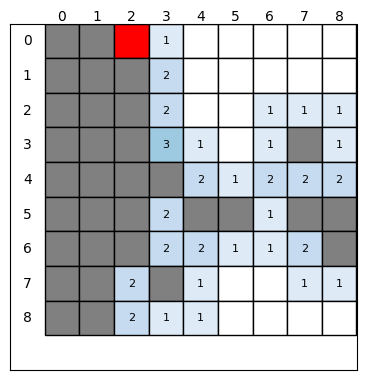

模擬遊戲中:  10%|▉         | 49/500 [01:07<09:28,  1.26s/it]

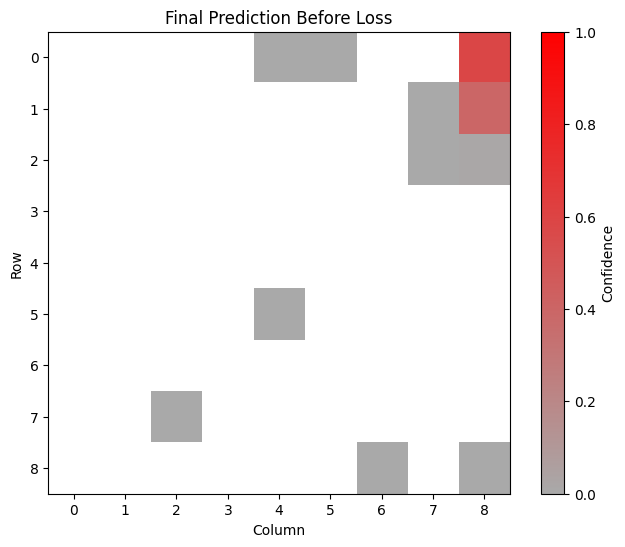

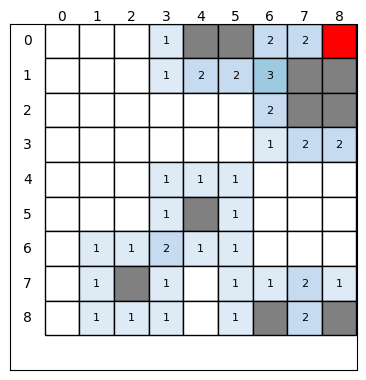

模擬遊戲中:  11%|█         | 54/500 [01:12<07:32,  1.01s/it]

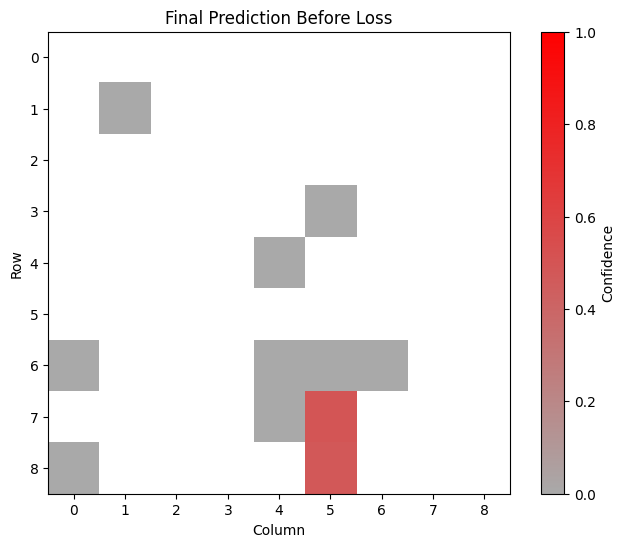

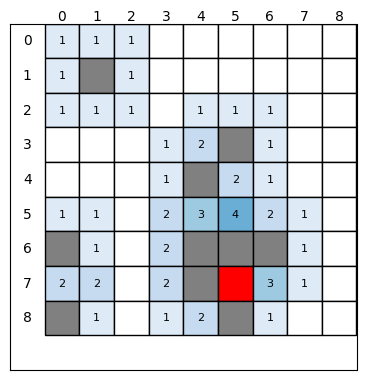

模擬遊戲中:  13%|█▎        | 63/500 [01:24<09:19,  1.28s/it]

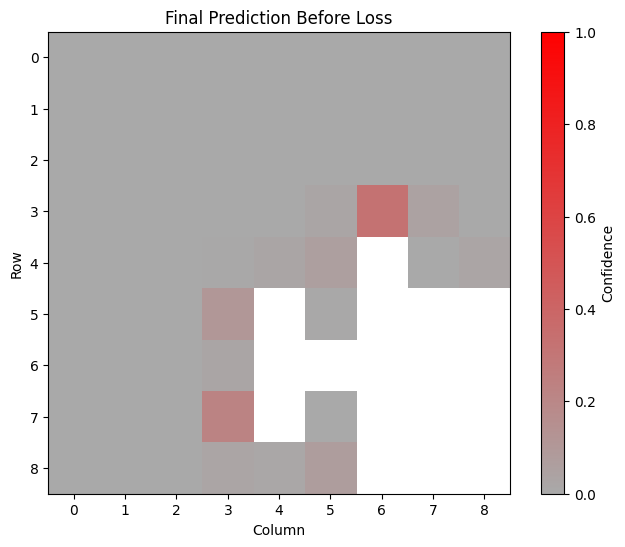

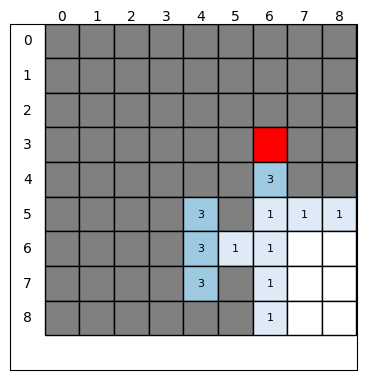

模擬遊戲中:  13%|█▎        | 64/500 [01:25<08:43,  1.20s/it]

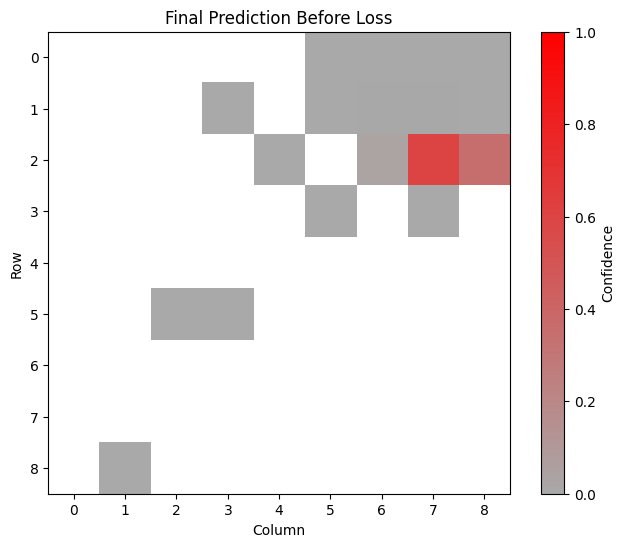

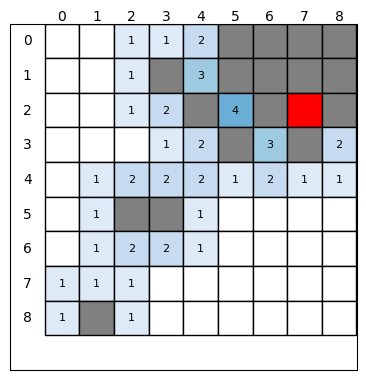

模擬遊戲中:  18%|█▊        | 88/500 [01:57<09:56,  1.45s/it]

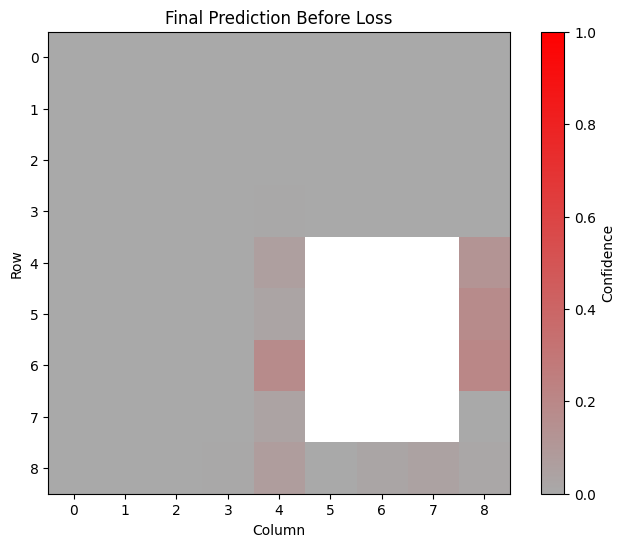

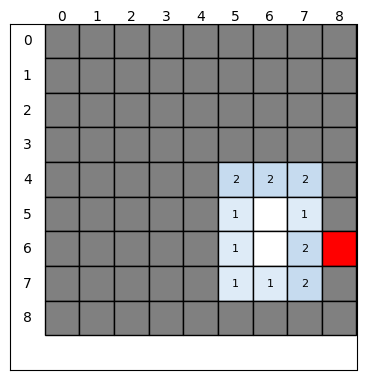

模擬遊戲中:  19%|█▉        | 96/500 [02:06<07:43,  1.15s/it]

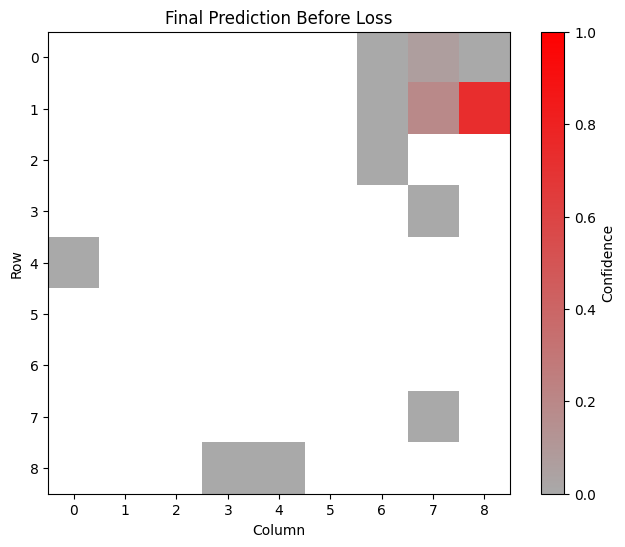

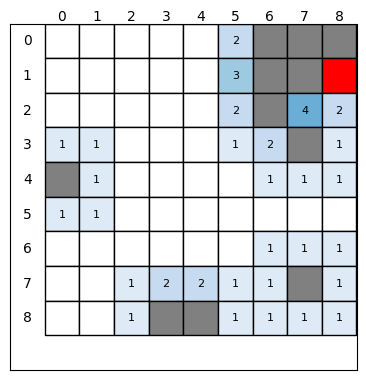

模擬遊戲中:  20%|█▉        | 98/500 [02:09<08:05,  1.21s/it]

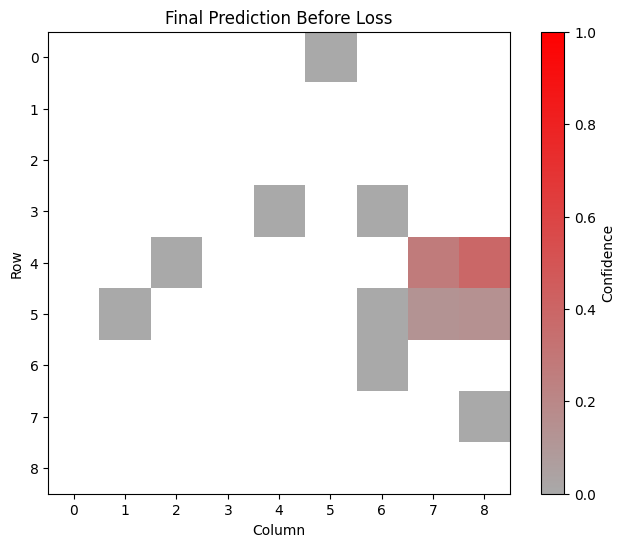

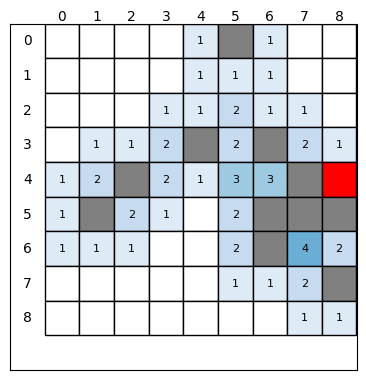

模擬遊戲中:  24%|██▎       | 118/500 [02:38<08:29,  1.33s/it]

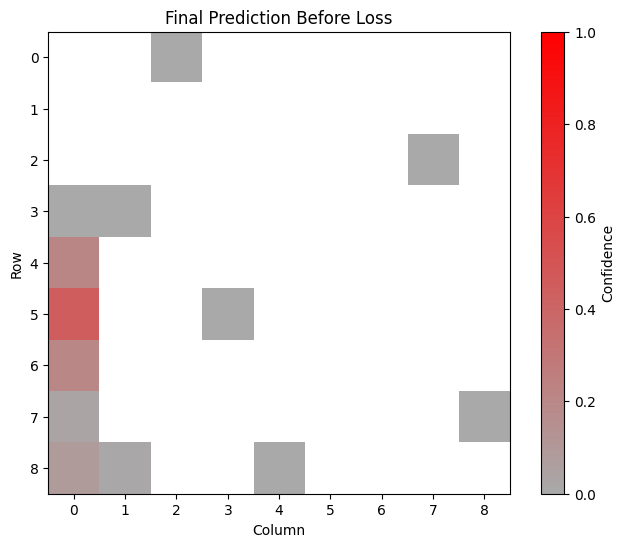

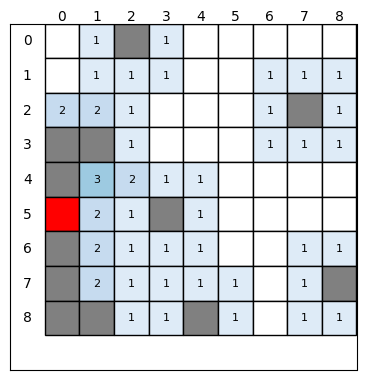

模擬遊戲中:  26%|██▌       | 130/500 [02:53<05:46,  1.07it/s]

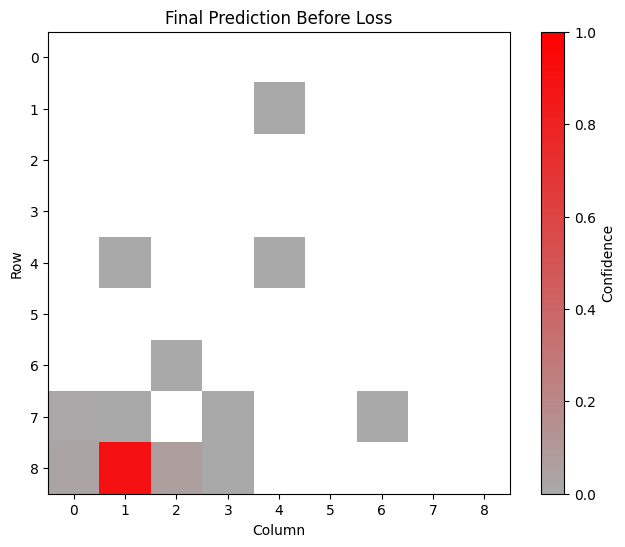

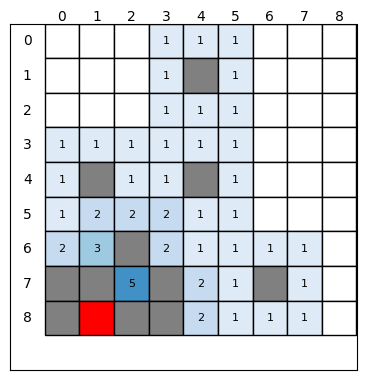

模擬遊戲中:  26%|██▌       | 131/500 [02:55<08:15,  1.34s/it]

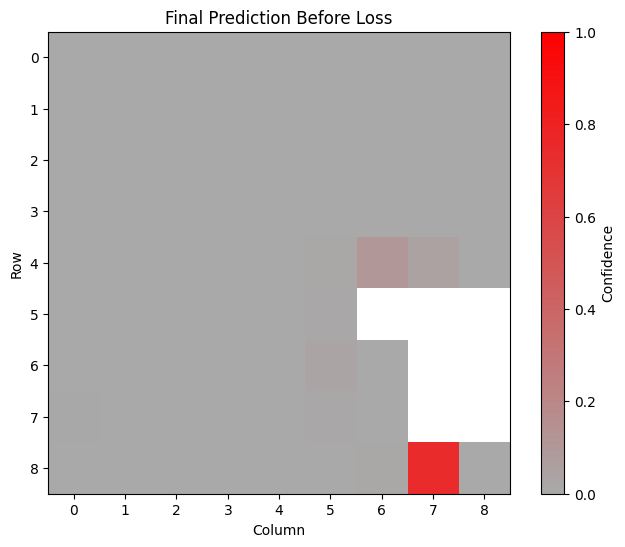

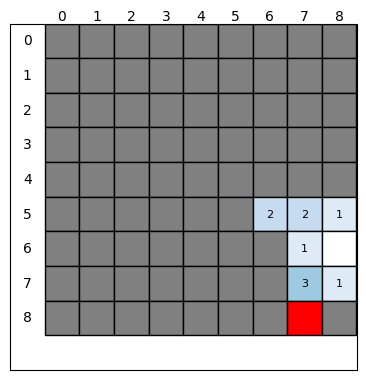

模擬遊戲中:  27%|██▋       | 134/500 [02:58<06:49,  1.12s/it]

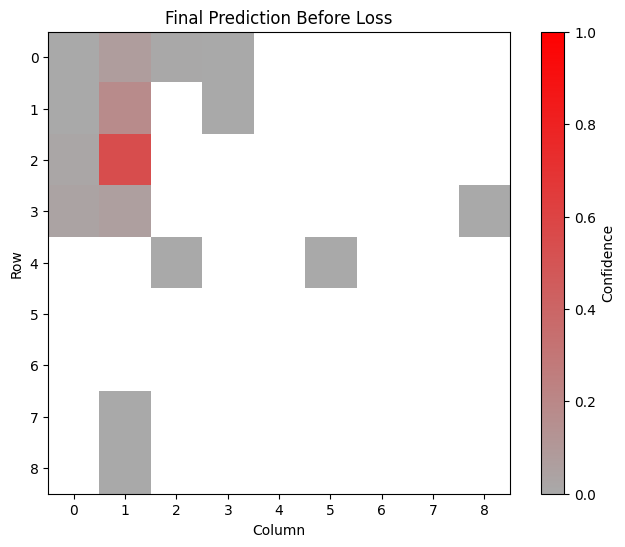

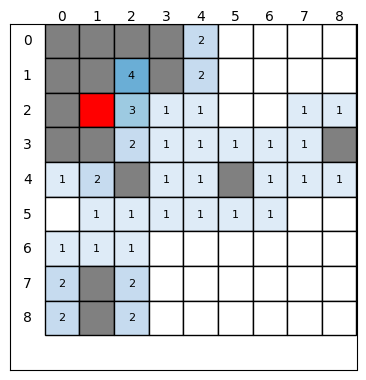

模擬遊戲中:  31%|███       | 153/500 [03:26<08:57,  1.55s/it]

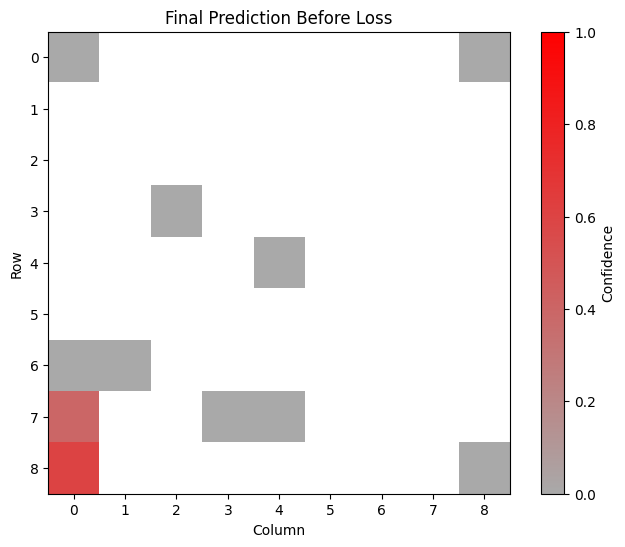

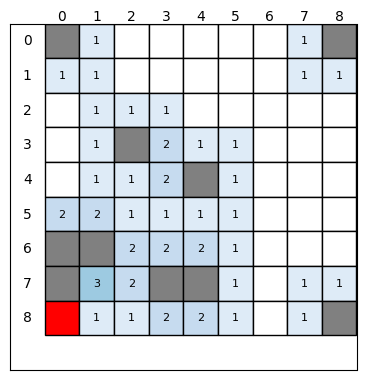

模擬遊戲中:  33%|███▎      | 167/500 [03:43<05:53,  1.06s/it]

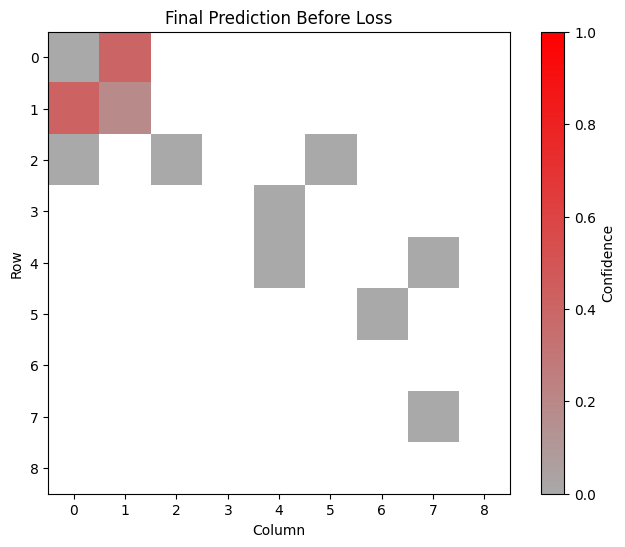

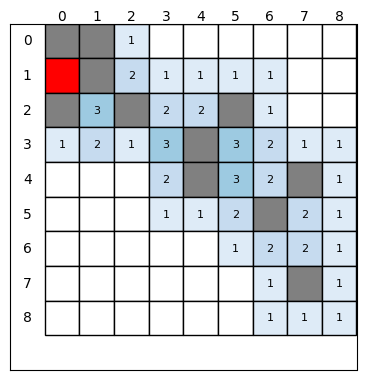

模擬遊戲中:  36%|███▌      | 181/500 [04:04<07:35,  1.43s/it]

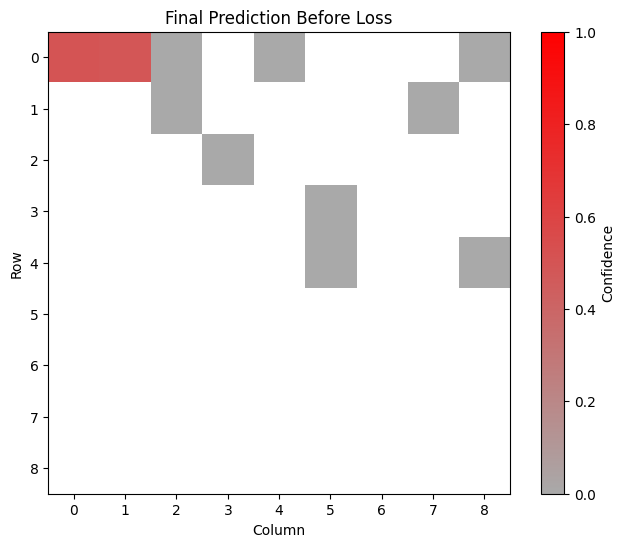

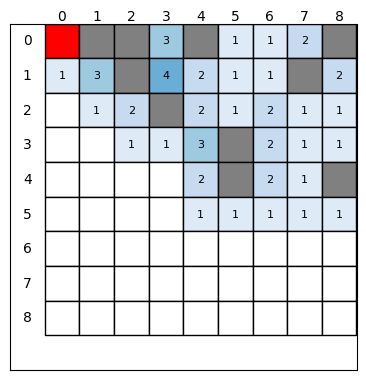

模擬遊戲中:  39%|███▊      | 193/500 [04:20<06:39,  1.30s/it]

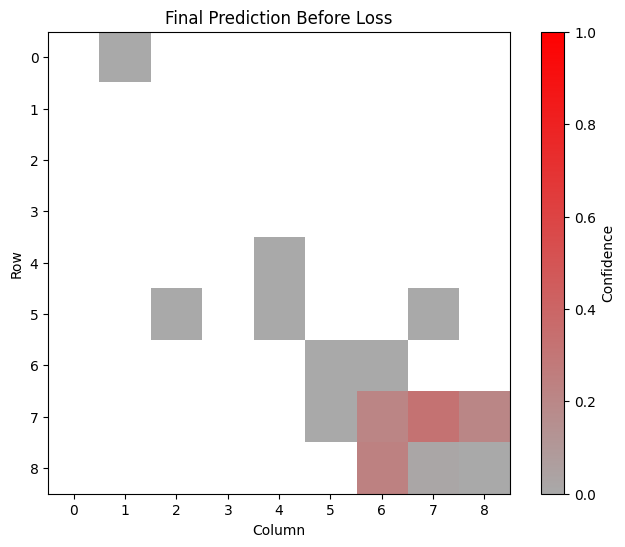

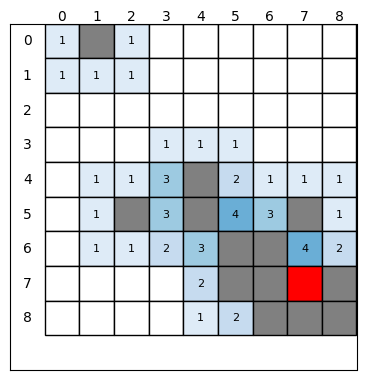

模擬遊戲中:  41%|████▏     | 207/500 [04:39<06:26,  1.32s/it]

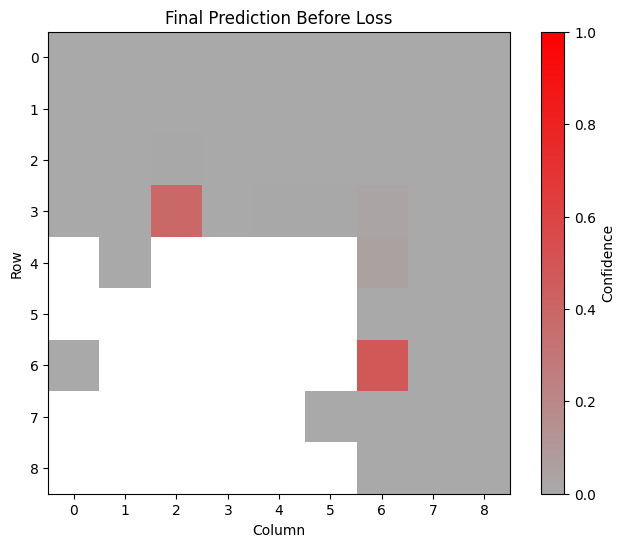

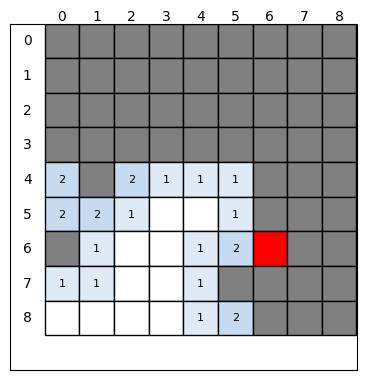

模擬遊戲中:  43%|████▎     | 213/500 [04:45<05:27,  1.14s/it]

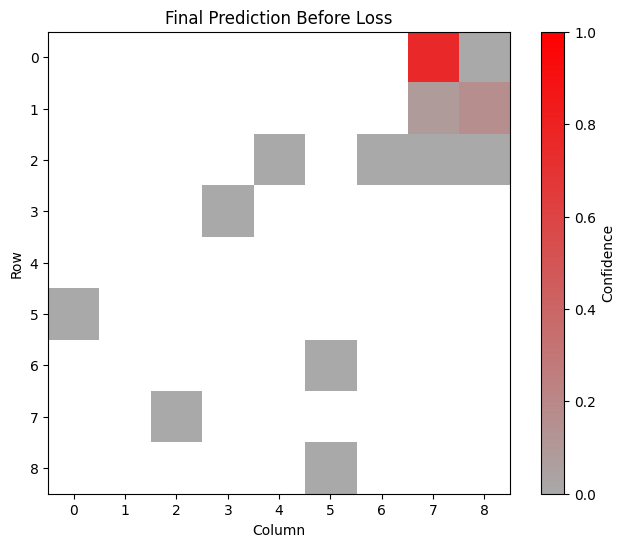

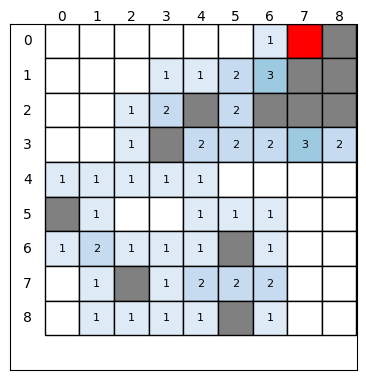

模擬遊戲中:  55%|█████▌    | 277/500 [06:14<05:15,  1.42s/it]

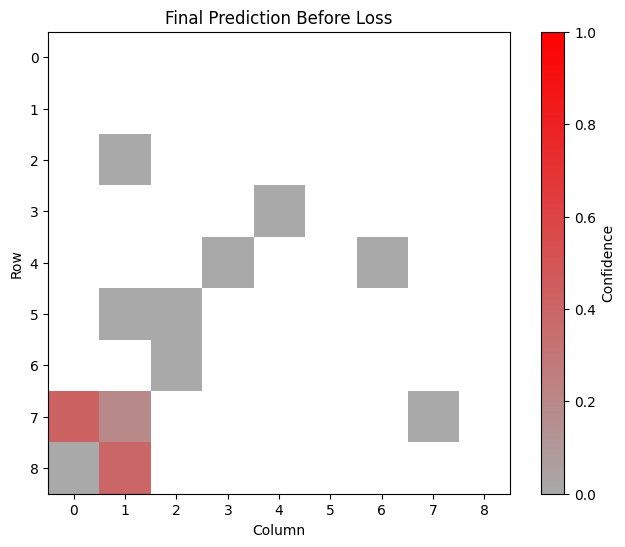

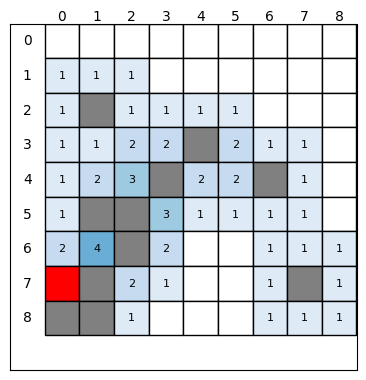

模擬遊戲中:  59%|█████▉    | 295/500 [06:38<04:11,  1.23s/it]

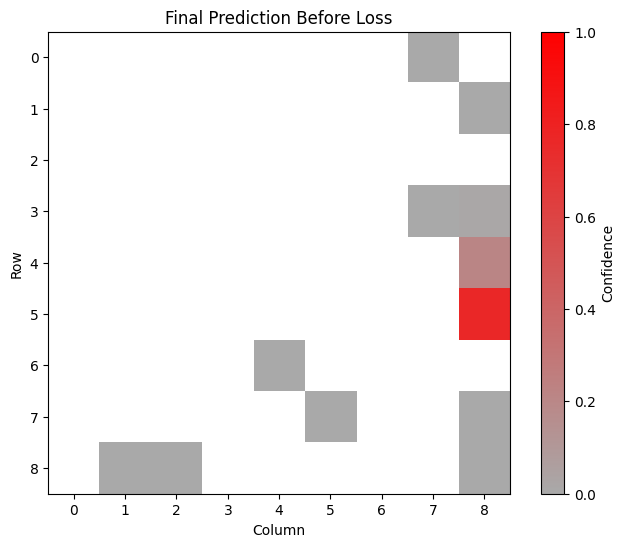

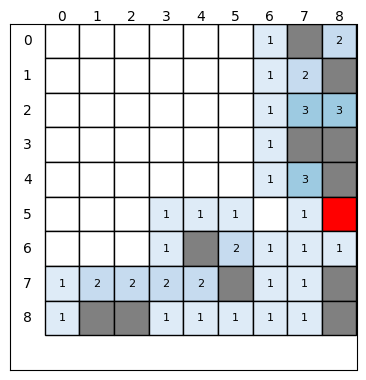

模擬遊戲中:  61%|██████    | 305/500 [06:51<04:40,  1.44s/it]

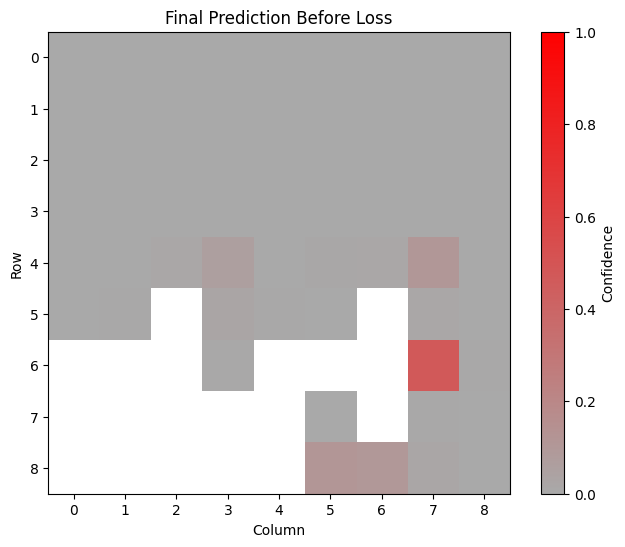

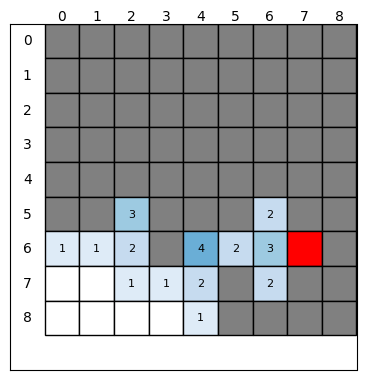

模擬遊戲中:  67%|██████▋   | 333/500 [07:31<04:06,  1.47s/it]

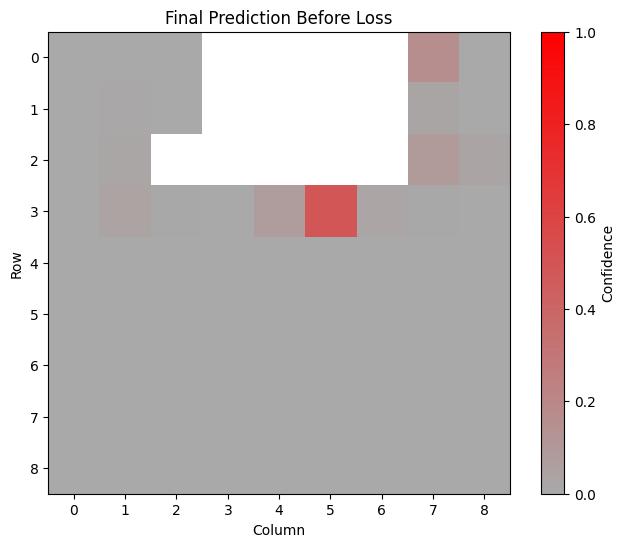

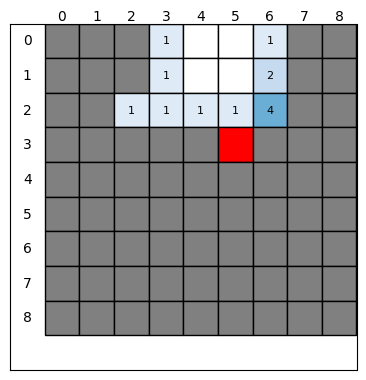

模擬遊戲中:  70%|██████▉   | 348/500 [07:52<03:13,  1.27s/it]

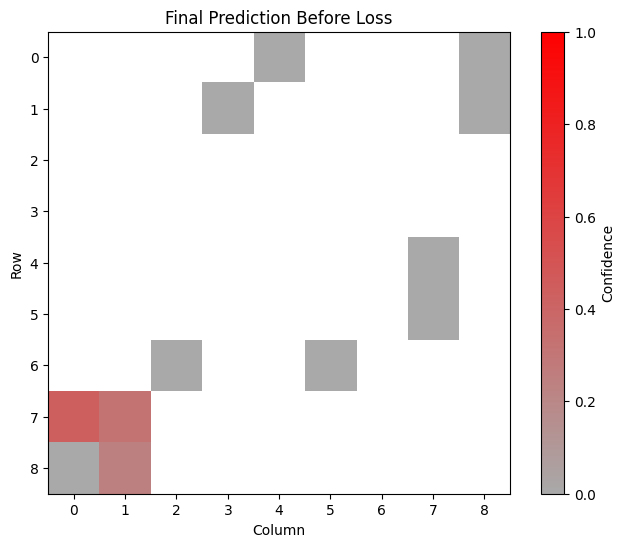

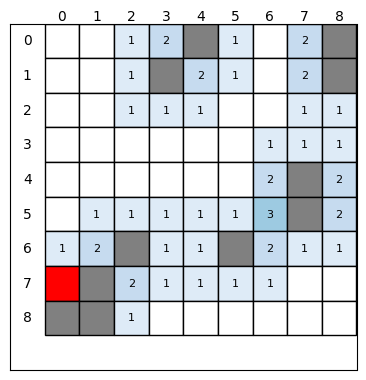

模擬遊戲中:  74%|███████▍  | 369/500 [08:17<02:13,  1.02s/it]

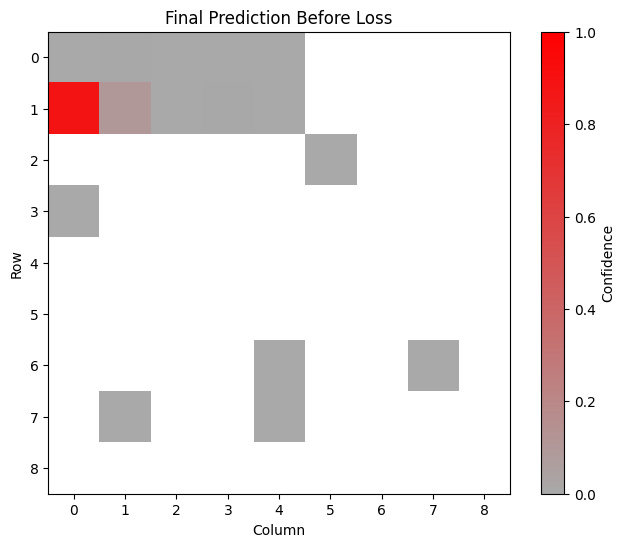

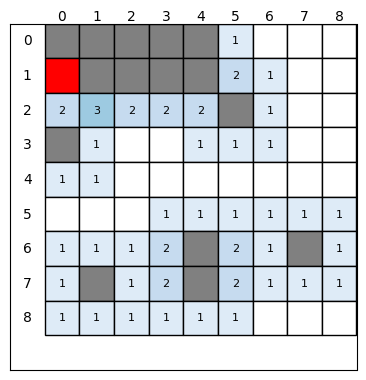

模擬遊戲中:  77%|███████▋  | 386/500 [08:40<02:38,  1.39s/it]

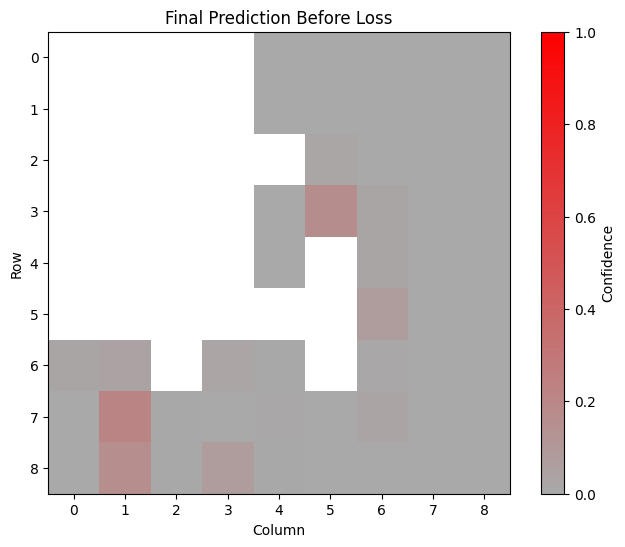

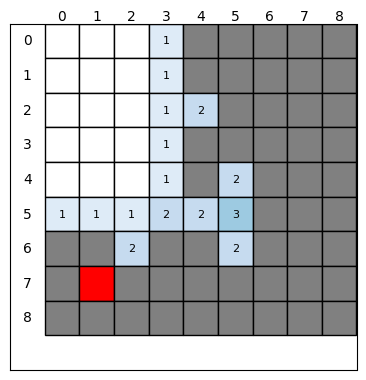

模擬遊戲中:  80%|████████  | 402/500 [09:02<02:18,  1.41s/it]

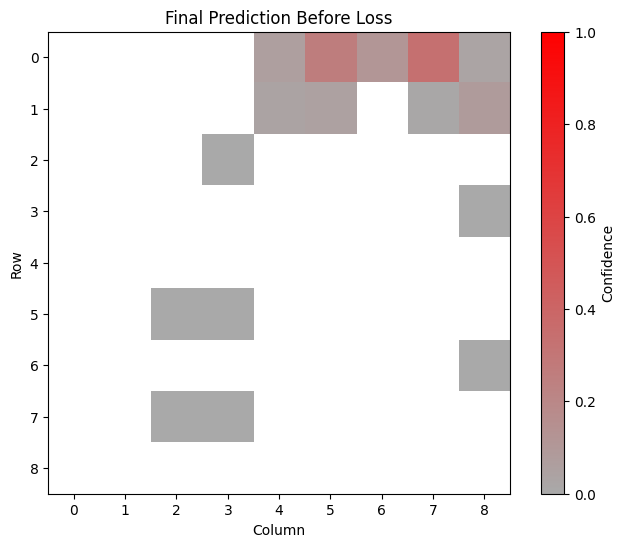

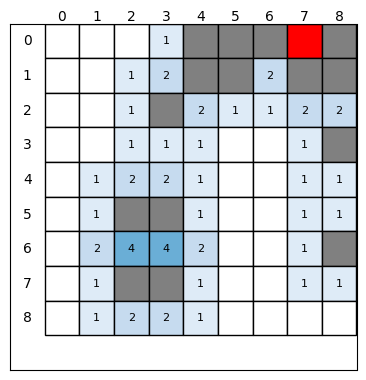

模擬遊戲中:  82%|████████▏ | 411/500 [09:13<01:25,  1.04it/s]

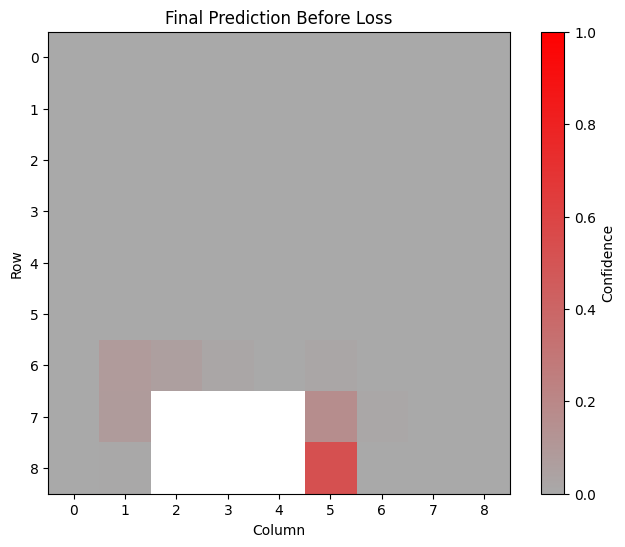

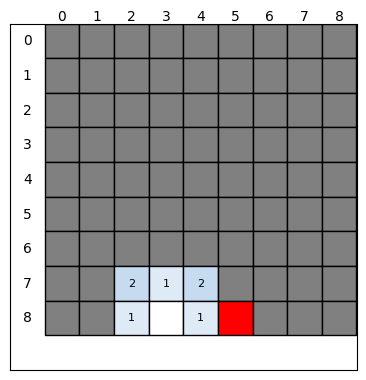

模擬遊戲中:  89%|████████▉ | 445/500 [10:03<01:24,  1.54s/it]

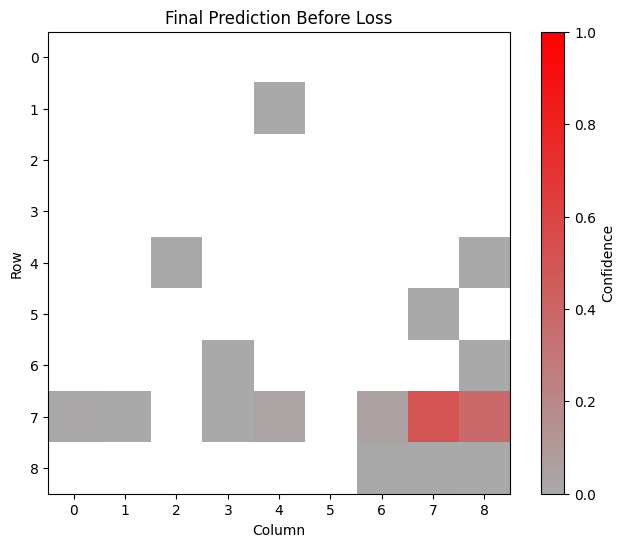

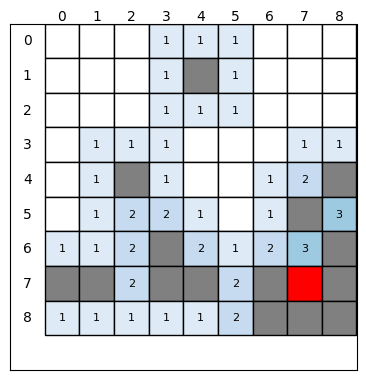

模擬遊戲中: 100%|██████████| 500/500 [11:14<00:00,  1.35s/it]

模擬 500 場遊戲，勝率為：93.60%


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm  # 用於顯示進度條
from matplotlib.colors import LinearSegmentedColormap
import copy

def visualize_prediction(prediction, play_simulation, title="Model Prediction"):
    """
    利用顏色漸層將預測結果進行可視化：
    - 已翻開的格子顯示為白色
    - 機率越低越深灰
    - 機率越高越紅
    """
    # 複製預測結果
    visualization = np.copy(prediction)
    
    # 處理已翻開或插旗的格子
    for x in range(visualization.shape[0]):
        for y in range(visualization.shape[1]):
            if play_simulation[x][y] != -2:  # 已翻開或插旗的格子
                visualization[x][y] = np.nan  # 設置為 NaN 表示白色
            else:
                visualization[x][y] = np.clip(visualization[x][y], 0, 1)  # 將機率限制在 0 到 1 範圍內
    
    # 創建自訂的從深灰到紅色的顏色映射
    custom_cmap = LinearSegmentedColormap.from_list("grey_red", ["darkgrey", "red"])
    custom_cmap.set_bad(color='white')  # 將 NaN 顯示為白色
    
    # 繪製圖像
    plt.figure(figsize=(8, 6))
    img = plt.imshow(
        visualization,
        cmap=custom_cmap,  # 使用自訂的顏色映射
        interpolation="nearest",
        vmin=0,
        vmax=1
    )
    plt.colorbar(img, label="Confidence")
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()
    
def simulate_game(model, width, height, num_mines, Print_board=0, first_step=0):
    """
    使用訓練好的模型模擬一場踩地雷遊戲，返回遊戲是否成功。
    """
    # 初始化遊戲
    game = Minesweeper(width, height, num_mines)
    game._reset()

    if first_step == 2:
        # 找出所有數字為 0 的格子
        zero_positions = [
            (i, j) for i in range(game.height)
            for j in range(game.width)
            if game.board[i][j].adjacent_mines == 0 and not game.board[i][j].is_mine
        ]

        if zero_positions:
            # 隨機選擇其中一個格子作為第一步
            x, y = random.choice(zero_positions)
            game.reveal_cell(x, y)
        else:
            # 如果沒有數字為0的格子，隨機選擇一個格子
            x, y = random.randint(0, height - 1), random.randint(0, width - 1)
            game.reveal_cell(x, y)

    if Print_board == 1:
        game.draw_board()

    # 使用 NumPy 初始化 prediction，便於後續操作
    prediction = np.full((height, width), -2.0)

    while not game.game_over:
        # 將遊戲棋盤轉為 NumPy 陣列
        current_board = np.array(game.play_simulation)

        # 將小於 0 的值轉為 -8
        current_board[current_board < 0] = -8

        # 將棋盤正規化到 [-1, 1] 範圍
        current_board = current_board / 8.0
        current_board = current_board.reshape(1, height, width, 1)

        # 保存當前的 prediction 和 play_simulation 作為 old_prediction 和 old_play_simulation
        old_prediction = copy.deepcopy(prediction)
        old_play_simulation = copy.deepcopy(game.play_simulation)

        # 使用模型預測下一步
        prediction = model.predict(current_board, verbose=0)
        prediction = prediction.reshape(height, width)  # 將預測結果轉回棋盤形狀

        # 對已翻開的格子設置低置信度
        for x in range(height):
            for y in range(width):
                if game.play_simulation[x][y] != -2:  # 如果該格子已翻開或插旗
                    prediction[x][y] = -np.inf

        # 可視化預測結果
        if Print_board == 1:
            visualize_prediction(prediction, game.play_simulation, title="Model Prediction")

        # 獲取置信度最高的格子
        # 使用 np.argmax 忽略 -np.inf 的值
        if np.all(prediction == -np.inf):
            # 如果所有格子都被揭示或插旗，遊戲結束
            break

        x, y = np.unravel_index(np.argmax(prediction), prediction.shape)

        # 翻開預測的格子
        game.reveal_cell(x, y)
        if Print_board == 1:
            game.draw_board()

    if Print_board == -1 and game.revealed_cells != game.total_cells:
        # 使用漸層塗色繪製最終盤面
        visualize_prediction(prediction, old_play_simulation, title="Final Prediction Before Loss")
        game.draw_board()

    # 判斷遊戲結果
    return game.revealed_cells == game.total_cells
    
def run_simulation(model, width, height, num_mines, num_games, Print_board=0, first_step=0):
    """
    模擬多次遊戲並計算勝率。
    """
    wins = 0

    for _ in tqdm(range(num_games), desc="模擬遊戲中"):
        if simulate_game(model, width, height, num_mines, Print_board, first_step):
            wins += 1

    win_rate = wins / num_games
    print(f"模擬 {num_games} 場遊戲，勝率為：{win_rate:.2%}")
    return win_rate
    
if __name__ == "__main__":
    # 模型路徑（已訓練好的模型）
    model_path = ""
    width, height, num_mines = 0, 0, 0
    
    #選擇難度
    game_difficulty = 0
    
    if game_difficulty==0:
       # model_path = "/kaggle/input/minesweeper_beginner_model/keras/default/1/minesweeper_Beginner_5epochs_80win-rate.h5"
       # model_path = "/kaggle/input/minesweeper_beginner_model/keras/default/1/minesweeper_Beginner_50epochs_nbr_cor_87win-rate.h5"
        model_path = "/kaggle/input/minesweeper_beginner_model/keras/default/1/minesweeper_Beginner_50epochs_nbr_cor_up_91win-rate.h5"
        width, height, num_mines = 9, 9, 10
        
    if game_difficulty==1:
        model_path = "/kaggle/working/minesweeper_Intermediate_50epochs_nbr_cor_up.h5"
        width, height, num_mines = 16, 16, 40
        
    if game_difficulty==2:
        model_path = "/kaggle/working/minesweeper_Expert_50epochs_nbr_cor_up.h5"
        width, height, num_mines = 30, 16, 99

    # 載入訓練好的模型
    trained_model = tf.keras.models.load_model(model_path)

    # 模擬遊戲參數
    win_rate = run_simulation(model=trained_model, width=width, height=height, num_mines=num_mines, num_games=500, Print_board=-1, first_step=2)

    """
    for i in range(10,21):
        # 模擬遊戲參數
        num_mines = i
        win_rate = run_simulation(model=trained_model, width=width, height=height, num_mines=num_mines, num_games=500, Print_board=0, first_step=2)
        print(f"width: {width} height: {height} num_mines: {num_mines} win_rate: {win_rate}\n")
    """
    